In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from matplotlib.gridspec import GridSpec
from llm_deliberation.utils import bootstrap_statistic_df, jaccard, change_of_minds
from scipy.stats import mannwhitneyu

from pyprojroot import here
from mpl_lego.labels import bold_text, add_significance_bracket_inplot, apply_subplot_labels
from mpl_lego.style import use_latex_style

In [4]:
use_latex_style()

In [5]:
with open(here('data/analysis/exp1_sync_h2h.pkl'), 'rb') as file:
    exp1 = pickle.load(file)

with open(here('data/analysis/exp5_sync_h2h.pkl'), 'rb') as file:
    exp2 = pickle.load(file)

with open(here('data/analysis/exp6_sync_h2h.pkl'), 'rb') as file:
    exp3 = pickle.load(file)

In [6]:
with open(here('data/analysis/exp8_sync_h2h.pkl'), 'rb') as file:
    gpt = pickle.load(file)

with open(here('data/analysis/exp7_sync_h2h.pkl'), 'rb') as file:
    claude = pickle.load(file)

with open(here('data/analysis/exp9_sync_h2h.pkl'), 'rb') as file:
    gemini = pickle.load(file)

In [18]:
with open(here('data/analysis/exp1a_round_robin_h2h.pkl'), 'rb') as file:
    exp3b = pickle.load(file)

with open(here('data/analysis/exp1b_round_robin_h2h.pkl'), 'rb') as file:
    exp3a = pickle.load(file)

with open(here('data/analysis/exp2a_round_robin_h2h.pkl'), 'rb') as file:
    exp2a = pickle.load(file)

with open(here('data/analysis/exp2b_round_robin_h2h.pkl'), 'rb') as file:
    exp2b = pickle.load(file)

with open(here('data/analysis/exp3a_round_robin_h2h.pkl'), 'rb') as file:
    exp1b = pickle.load(file)

with open(here('data/analysis/exp3b_round_robin_h2h.pkl'), 'rb') as file:
    exp1a = pickle.load(file)

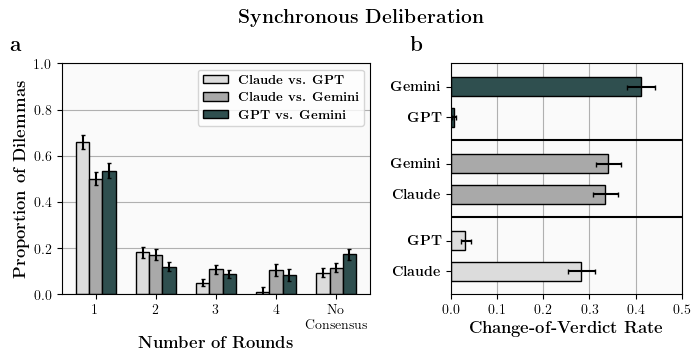

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 0.75]})
fig.subplots_adjust(wspace=0.3)

dfs = [exp1, exp2, exp3]
colors = ['gainsboro', 'darkgray', 'darkslategray']
labels = bold_text(['Claude vs. GPT', 'Claude vs. Gemini', 'GPT vs. Gemini'])
n_rounds_range = [1, 2, 3, 4]
bar_width = 0.22
x = np.arange(len(n_rounds_range) + 1)

for i, df in enumerate(dfs):
    counts = df['n_rounds'].value_counts()
    counts[4] = counts.get(4, 0) - df['final_verdict'].isna().sum()
    counts = counts.reindex(n_rounds_range, fill_value=0)
    counts = counts / df.shape[0]

    no_consensus = df['final_verdict'].isna().sum() / df.shape[0]
    bar_heights = list(counts.values) + [no_consensus]

    # --- Bootstrap errors ---
    lower_errs, upper_errs = [], []
    for round_val in n_rounds_range:
        boot = bootstrap_statistic_df(
            df=df,
            statistic_func=lambda x, rv=round_val: (x['n_rounds'] == rv).mean(),
            n_bootstrap=1000,
            confidence_level=0.95
        )
        lower_errs.append(boot['lower_err'])
        upper_errs.append(boot['upper_err'])

    # No consensus bootstrap
    boot_nc = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: x['final_verdict'].isna().mean(),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    lower_errs.append(boot_nc['lower_err'])
    upper_errs.append(boot_nc['upper_err'])

    yerr = np.array([lower_errs, upper_errs])

    axes[0].bar(
        x + (i - 1) * bar_width,
        bar_heights,
        width=bar_width,
        color=colors[i],
        edgecolor='black',
        label=labels[i],
        align='center',
        yerr=yerr,
        capsize=1.5)

# Draw a horizontal line at the mean for n_rounds == 1, spanning the first bar only
axes[0].plot(
    1, (gpt['n_rounds'] == 1).mean(),
    color='black',
    linewidth=2
)
axes[0].plot(
    1, (claude['n_rounds'] == 1).mean(),
    color='black',
    linewidth=2
)
axes[0].plot(
    1, (gemini['n_rounds'] == 1).mean(),
    color='black',
    linewidth=2
)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y')
axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize=10)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['1', '2', '3', '4', 'No\nConsensus'])
axes[0].set_xlabel(bold_text('Number of Rounds'), fontsize=12)
axes[0].set_ylabel(bold_text('Proportion of Dilemmas'), fontsize=12)
axes[0].legend(fontsize=9)

all_ticks = []

for idx, df in enumerate(dfs):
    # positions
    ticks = [2 * idx - 0.4 + 1, 2 * idx + 0.4 + 1]

    # point estimates
    w1 = change_of_minds(df['Agent_1_verdicts'], mean=True)
    w2 = change_of_minds(df['Agent_2_verdicts'], mean=True)

    # --- Bootstrap errors for flip rates ---
    boot1 = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    boot2 = bootstrap_statistic_df(
        df=df,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000,
        confidence_level=0.95
    )
    xerr = np.array([
        [boot1['lower_err'], boot2['lower_err']],  # lower errors
        [boot1['upper_err'], boot2['upper_err']]   # upper errors
    ])

    axes[1].barh(
        y=ticks,
        width=[w1, w2],
        height=0.5,
        color=colors[idx],
        edgecolor='black',
        xerr=xerr,
        error_kw={'capsize': 1.8}
    )
    all_ticks.extend(ticks)

axes[1].axhline(2, linestyle='-', color='black')
axes[1].axhline(4, linestyle='-', color='black')

axes[1].set_xlim([0, 0.5])
axes[1].set_ylim([0, 6])
axes[1].set_yticks(all_ticks)
axes[1].set_yticklabels(bold_text(['Claude', 'GPT', 'Claude', 'Gemini', 'GPT', 'Gemini']))
axes[1].grid(axis='x')
axes[1].set_axisbelow(True)
axes[1].set_xlabel(bold_text('Change-of-Verdict Rate'), fontsize=12)

for ax in axes:
    ax.set_facecolor(color='0.98')

apply_subplot_labels(axes, bold=True, y=1.08)
fig.suptitle(bold_text('Synchronous Deliberation'), fontsize=14, y=1.06)
plt.savefig('figure_rounds_left.pdf', bbox_inches='tight')

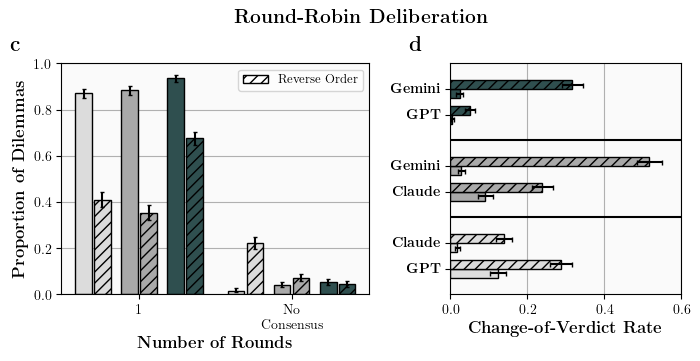

In [89]:
# --- figure & layout ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 0.75]})
fig.subplots_adjust(wspace=0.3)

# data order: A then B per matchup
dfs   = [exp1a, exp1b, exp2a, exp2b, exp3a, exp3b]
pairs = [('GPT', 'Claude'), ('Claude', 'Gemini'), ('GPT', 'Gemini')]

colors  = ['gainsboro', 'darkgray', 'darkslategray']  # per matchup
hatch_B = '///'

# ===================== LEFT: P(1 round) & P(No consensus) =====================
cats = ['1', 'No\nConsensus']

# cluster geometry (3 matchups × (A,B))
bar_width = 0.18          # width of a single bar
ab_gap    = 0.03          # A vs B within a matchup
group_gap = 0.12          # gap between matchups

num_groups = len(pairs)

def group_offset(gidx, is_B):
    """Offset within a category center."""
    within = 1 if is_B else 0
    group_center = (gidx - (num_groups - 1)/2) * (2*bar_width + ab_gap + group_gap)
    within_offset = (within - 0.5) * (bar_width + ab_gap)
    return group_center + within_offset

# ---- category centers (bigger gap) ----
max_group_span = ((num_groups - 1)/2) * (2*bar_width + ab_gap + group_gap)
max_within     = 0.5 * (bar_width + ab_gap)
max_offset     = max_group_span + max_within
sep            = 1.2 * (max_offset + bar_width/2)   # bump factor for a cleaner gap

x = np.array([-sep, +sep])  # category centers at symmetric positions

for j, df in enumerate(dfs):
    g = j // 2
    is_B = (j % 2 == 1)
    offset = group_offset(g, is_B)

    # stats
    p1  = (df['n_rounds'] == 1).mean()
    pnc = df['final_verdict'].isna().mean()
    bars = [p1, pnc]

    boot1 = bootstrap_statistic_df(df=df,
        statistic_func=lambda x: (x['n_rounds'] == 1).mean(),
        n_bootstrap=1000, confidence_level=0.95)
    bootN = bootstrap_statistic_df(df=df,
        statistic_func=lambda x: x['final_verdict'].isna().mean(),
        n_bootstrap=1000, confidence_level=0.95)
    yerr = np.array([[boot1['lower_err'], bootN['lower_err']],
                     [boot1['upper_err'], bootN['upper_err']]])

    axes[0].bar(
        x + offset, bars,
        width=bar_width,
        color=colors[g],
        edgecolor='black',
        hatch=(hatch_B if is_B else None),
        align='center',
        yerr=yerr, capsize=1.5
    )

axes[0].set_ylim([0, 1])
axes[0].grid(axis='y'); axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize=10)
axes[0].set_xticks(x); axes[0].set_xticklabels(cats)
axes[0].set_xlabel(bold_text('Number of Rounds'), fontsize=12)
axes[0].set_ylabel(bold_text('Proportion of Dilemmas'), fontsize=12)

# simple legend: hatch semantics only
from matplotlib.patches import Patch
axes[0].legend(
    handles=[Patch(facecolor='white', edgecolor='black', hatch=hatch_B, label='Reverse Order')],
    fontsize=9, frameon=True, loc='upper right'
)

# ===================== RIGHT: change-of-verdict (A/B touching per model) =====================
axes[1].cla()

pair_height = 0.36
# make A/B bars *touch* by setting centers exactly one bar-height apart,
# minus a tiny epsilon to avoid antialiasing gaps.
dy = pair_height/2 - 1e-3

yticks_centers = []
ytick_labels_plain = []

for m, (a, b) in enumerate(pairs):
    color = colors[m]
    df_A, df_B = dfs[2*m], dfs[2*m + 1]

    # row centers (a then b)
    y_a = 3*m + 1
    y_b = 3*m + 2

    # --- model a row: A(solid) next to B(hatched) ---
    w_a_A = change_of_minds(df_A['Agent_1_verdicts'], mean=True)
    w_a_B = change_of_minds(df_B['Agent_2_verdicts'], mean=True)
    boot_a_A = bootstrap_statistic_df(df=df_A,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)
    boot_a_B = bootstrap_statistic_df(df=df_B,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)

    axes[1].barh(y=y_a - dy, width=w_a_A, height=pair_height,
                 color=color, edgecolor='black')
    axes[1].errorbar(x=w_a_A, y=y_a - dy,
                     xerr=[[boot_a_A['lower_err']], [boot_a_A['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')
    axes[1].barh(y=y_a + dy, width=w_a_B, height=pair_height,
                 color=color, edgecolor='black', hatch=hatch_B)
    axes[1].errorbar(x=w_a_B, y=y_a + dy,
                     xerr=[[boot_a_B['lower_err']], [boot_a_B['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')

    # --- model b row: A(solid) next to B(hatched) ---
    w_b_A = change_of_minds(df_A['Agent_2_verdicts'], mean=True)
    w_b_B = change_of_minds(df_B['Agent_1_verdicts'], mean=True)
    boot_b_A = bootstrap_statistic_df(df=df_A,
        statistic_func=lambda x: change_of_minds(x['Agent_2_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)
    boot_b_B = bootstrap_statistic_df(df=df_B,
        statistic_func=lambda x: change_of_minds(x['Agent_1_verdicts'], mean=True),
        n_bootstrap=1000, confidence_level=0.95)

    axes[1].barh(y=y_b - dy, width=w_b_A, height=pair_height,
                 color=color, edgecolor='black')
    axes[1].errorbar(x=w_b_A, y=y_b - dy,
                     xerr=[[boot_b_A['lower_err']], [boot_b_A['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')
    axes[1].barh(y=y_b + dy, width=w_b_B, height=pair_height,
                 color=color, edgecolor='black', hatch=hatch_B)
    axes[1].errorbar(x=w_b_B, y=y_b + dy,
                     xerr=[[boot_b_B['lower_err']], [boot_b_B['upper_err']]],
                     fmt='none', capsize=1.8, ecolor='black')

    yticks_centers.extend([y_a, y_b])
    ytick_labels_plain.extend([a, b])

# separators between matchup sections
axes[1].axhline(3, linestyle='-', color='black')
axes[1].axhline(6, linestyle='-', color='black')

axes[1].set_xlim([0, 0.6])
axes[1].set_ylim([0, 9])
axes[1].set_yticks(yticks_centers)
axes[1].set_yticklabels(bold_text(ytick_labels_plain))
axes[1].grid(axis='x'); axes[1].set_axisbelow(True)
axes[1].set_xlabel(bold_text('Change-of-Verdict Rate'), fontsize=12)

# backgrounds + subplot labels
for ax in axes:
    ax.set_facecolor('0.98')
apply_subplot_labels(axes, bold=True, y=1.08, labels=['c', 'd'])

fig.suptitle(bold_text('Round-Robin Deliberation'), fontsize=14, y=1.06)
plt.savefig('figure_rounds_right.pdf', bbox_inches='tight')